In [27]:
import numpy as np
from matplotlib import pyplot as plt
import cv2 as cv
import os

In [28]:
# SIFT SETUP
MIN_GOOD_MATCHES = 10
clue_banner_template = cv.imread("clue-banner-filled.png", cv.IMREAD_GRAYSCALE)
img_target = clue_banner_template
sift = cv.SIFT_create()
# What is the None parameter?
keypoints_target, descriptors_target = sift.detectAndCompute(img_target, None)

In [29]:
# LETTER READING SETUP
letter_thresh_minHSV = (int(230/2), 10, 0)
letter_thresh_maxHSV = (int(250/2), 255, 255)

In [30]:
from tensorflow.keras import models
model = models.load_model('letter-recog-model.h5')

# METHODS

### SIFT

In [31]:
def flannMatcher(keypoints_search, descriptors_search):
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks=50)   # or pass empty dictionary
    flann = cv.FlannBasedMatcher(index_params, search_params)
    # Ratio test: first match is much better than second (similarity ratio at least 1:0.7)
    matches = flann.knnMatch(descriptors_target, descriptors_search, k=2)
    good_matches = []
    # for i,(m,n) in enumerate(matches):
    for m, n in matches:
        if m.distance < 0.7*n.distance:
            # matchesMask[i] = [1,0]
            good_matches.append(m)
    return good_matches

## Apply SIFT to find keypoints and compute their gradients for both images
def clueboard_img_from_frame(frame):
    if len(frame.shape) == 2:
        frame_gray = frame
    else:
        frame_gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    
    keypoints_search, descriptors_search = sift.detectAndCompute(frame_gray, None)
    good_matches = flannMatcher(keypoints_search, descriptors_search)

    if len(good_matches) > MIN_GOOD_MATCHES:
        target_pts = np.float32([keypoints_target[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        search_pts = np.float32([keypoints_search[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        # ransacReprojThreshold = 5.0 I assume to be the distance in pixels between homography-projected point and original matching keypoint
        # to be considered an inlier.

        # matrix will be the homography transforming FROM the 1st image TO the 2nd image
        matrix, mask = cv.findHomography(search_pts, target_pts, cv.RANSAC, 5.0)
        # matches_mask = mask.ravel().tolist()
        warped_frame = cv.warpPerspective(frame, matrix, (img_target.shape[1], img_target.shape[0]))
        return warped_frame
    else:
        return None

### CLUEBOARD READING

In [32]:
LETTER_IMG_DIM_Y = 80
LETTER_IMG_DIM_X = 64
LETTER_IMG_SHAPE = (LETTER_IMG_DIM_Y, LETTER_IMG_DIM_X)

# returns text corresponding to array letter_imgs in order (may give incorrect result)
# image must be of shape (LETTER_DIM_Y, LETTER_DIM_X)
# NOTE: Consider adding a CONFIDENCE check (sth like RANSAC ratio test)
def model_wrapper(letter_imgs):
    predictions = model.predict(letter_imgs)
    text = ''
    for prediction in predictions:
        text += chr(ord('A') + np.argmax(prediction))
    return text

## API Method
# Takes a clueboard subimage with a line of text (capital letters A-Z in Ubuntu Monospace font ~size 90) and returns the text on that image
    # If no letters are detected, an empty string ''. 
    # Correctness NOT guaranteed.
# May see if can work on grayscale or BGR image for computational efficiency (but HSV is most robust due to brightness invariance)
# @param img_BGR (np.ndarray) an image
# @return (string) the line of text detected on the image 
def text_from_line_image(img_BGR):
    img_HSV = cv.cvtColor(img_BGR, cv.COLOR_BGR2HSV)
    img_mask = cv.inRange(img_HSV, letter_thresh_minHSV, letter_thresh_maxHSV)
    contours_ext, hierarchy_ext = cv.findContours(img_mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    bounding_rects_ext = [cv.boundingRect(contour) for contour in contours_ext]
    # contours_ext_sorted = sorted(contours_ext, key=cv.boundingRect, reverse=True)
    bounding_rects_ext.sort()

    letter_imgs = []
    for bounding_rect in bounding_rects_ext:
        # NOTE: for existing network, must use solid image, and not outline. 

        # NOTE: Changed 2024-04-07: if a bounding box exceeds the letter image shape, return none (to avoid broadcasting error)
        # TODO: Reduce chances of this error by appropriate image pre-processing
        if (bounding_rect[2] > LETTER_IMG_DIM_X or bounding_rect[3] > LETTER_IMG_DIM_Y):
            return f'ERROR: TOO LARGE BOUNDING BOX DETECTED {bounding_rect}'
        
        subimg = np.copy(img_mask[bounding_rect[1] : bounding_rect[1] + bounding_rect[3], bounding_rect[0] : bounding_rect[0] + bounding_rect[2]])
        letter_img = np.zeros(LETTER_IMG_SHAPE, dtype=np.uint8)
        start_x = (LETTER_IMG_DIM_X - bounding_rect[2]) // 2
        start_y = (LETTER_IMG_DIM_Y - bounding_rect[3]) // 2
        letter_img[start_y : start_y + bounding_rect[3], start_x : start_x + bounding_rect[2]] = subimg
        letter_imgs.append(letter_img)

    letter_imgs_arr = np.array(letter_imgs).reshape(-1, LETTER_IMG_DIM_Y, LETTER_IMG_DIM_X)
    text = model_wrapper(letter_imgs_arr)
    return text

## Clue type and value from clueboard image in same shape as `clue-banner-filled.png`. 
# Image must be SIFTed to match clueboard template size. 
# Correctness not guaranteed.
# @param clueboard_img (np.ndarray) a cv2-BGR-compatible SIFTed clueboard image in same shape as `clue-banner-filled.png`
# @return a 2-tuple of (clue_type, clue_value), where the entries may be a string or None if no text detected (possibly one each)
def clue_type_and_value(clueboard_img):
    # First, split image into type and image sections
    clue_type_img = clueboard_img[35:115, 240:580]
    clue_value_img = clueboard_img[255:335, 20:580]

    clue_type = text_from_line_image(clue_type_img)
    clue_value = text_from_line_image(clue_value_img)

    return clue_type, clue_value

# TEST

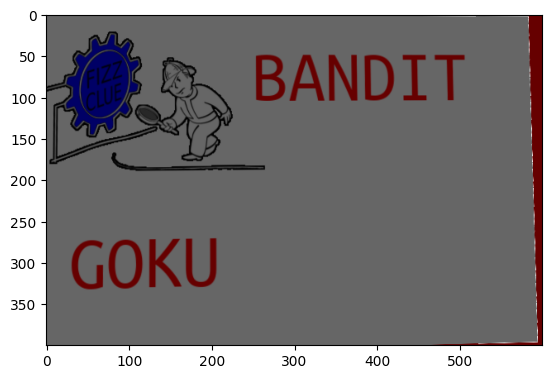

In [33]:
# SIFT TEST
frame_color = cv.imread('sign.png')
frame_gray = cv.cvtColor(frame_color, cv.COLOR_BGR2GRAY)
warped_frame = clueboard_img_from_frame(frame_color)
plt.imshow(warped_frame)

In [34]:
clue_type, clue_value = clue_type_and_value(warped_frame)
print(clue_type)
print(clue_value)

1/1 [==============================] - 0s 17ms/step
BANDIT
GOKU


### Sharpening images

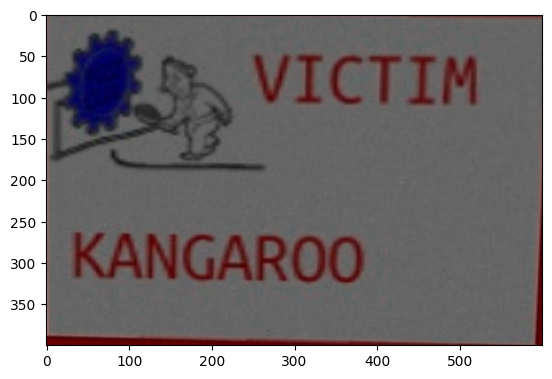

In [35]:
testimg = cv.imread(os.path.join('test-images', 'good-clues', 'victim-kangaroo', 'testimg-028.jpg'))
siftedimg = clueboard_img_from_frame(testimg)
plt.imshow(siftedimg)

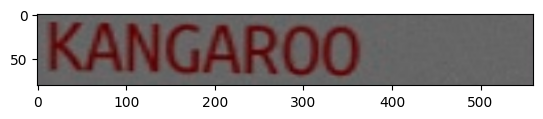

In [36]:
imgval = siftedimg[255:335, 20:580]
plt.imshow(imgval)

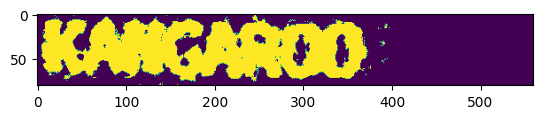

In [37]:
imgHSV = cv.cvtColor(imgval, cv.COLOR_BGR2HSV)
imgmask = cv.inRange(imgHSV, letter_thresh_minHSV, letter_thresh_maxHSV)
plt.imshow(imgmask)

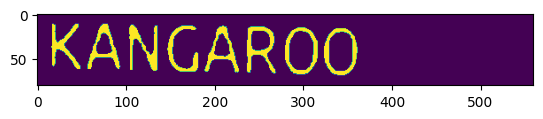

In [52]:
# LETTER READING SETUP
letter_thresh_minHSV = (int(230/2), 160, 16)
letter_thresh_maxHSV = (int(250/2), 255, 255)

imgHSV = cv.cvtColor(imgval, cv.COLOR_BGR2HSV)
imgmask = cv.inRange(imgHSV, letter_thresh_minHSV, letter_thresh_maxHSV)
plt.imshow(imgmask)

Making the min saturation threshold stricter clearly helps!